In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info

In [2]:
set_global_seed(42)
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
# data_path = Path("../data/sat2/split_stage_data_100hz_10samples.nc")
# data_path = Path("../data/ar/split_stage_data.nc")
# data_path = Path("../data/sat1/split_stage_data_unprocessed_500hz.nc")

dataset = xr.load_dataset(data_path)

In [7]:
data_path_sat1 = Path("../data/sat1/split_stage_data_100hz.nc")
dataset_sat1 = xr.load_dataset(data_path_sat1)

shape_topological = False
train_data_sat1, val_data_sat1, test_data_sat1 = split_data_on_participants(
    dataset_sat1, 60, norm_min1_to_1
)
train_dataset_sat1 = SAT1Dataset(train_data_sat1, shape_topological=shape_topological)
val_dataset_sat1 = SAT1Dataset(val_data_sat1, shape_topological=shape_topological)
test_dataset_sat1 = SAT1Dataset(test_data_sat1, shape_topological=shape_topological)

In [24]:
train_data, val_data, test_data = split_data_on_participants(
    dataset, 100, norm_min1_to_1
)

In [27]:
test_data

<xarray.Dataset>
Dimensions:      (channels: 30, samples: 10, epochs: 2446, participant: 0,
                  labels: 5)
Coordinates:
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 8 9
  * epochs       (epochs) int64 0 1 2 3 4 5 6 ... 2441 2442 2443 2444 2445 2446
  * participant  (participant) object 
  * labels       (labels) object 'confirmation' 'decision' ... 'response'
    event_name   (participant, epochs) object 
    rt           (participant, epochs) float64 
Data variables:
    data         (participant, epochs, labels, channels, samples) float64

In [3]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological)

In [ ]:
# model = TSTransformerEncoderClassiregressor(
#     feat_dim = len(train_data.channels),
#     max_len = len(train_data.samples),
#     d_model=512,
#     n_heads=16,
#     num_layers=6,
#     dim_feedforward=2048,
#     num_classes=len(train_data.labels),
# )
model = TSTransformerEncoderClassiregressor(
    feat_dim=len(train_data.channels),
    max_len=len(train_data.samples),
    d_model=256,
    n_heads=8,
    num_layers=6,
    dim_feedforward=2048,
    num_classes=len(train_data.labels),
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
)

In [ ]:
# TODO: Look into tensor device mismatch
model = TransformerModel(len(train_data.channels), 10, 512, 6, len(train_data.labels))

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=0,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
)

In [17]:
model = SAT1GRU(len(train_data.channels), len(val_data.samples), len(test_data.labels))

train_and_test(
    model,
    train_dataset,
    test_dataset,
    [val_dataset, train_dataset_sat1],
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
    label_smoothing=0.0001,
    weight_decay=0.001,
    do_spectral_decoupling=True,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

{'0': {'precision': 0.9808150119030948,
  'recall': 0.9096103896103896,
  'f1-score': 0.9438717067583048,
  'support': 7700.0},
 '1': {'precision': 0.861819932595089,
  'recall': 0.4247745609871856,
  'f1-score': 0.5690669209982515,
  'support': 8428.0},
 '2': {'precision': 0.7868754956383822,
  'recall': 0.9418604651162791,
  'f1-score': 0.8574206092028516,
  'support': 8428.0},
 '3': {'precision': 0.6666666666666666,
  'recall': 0.8450565666502705,
  'f1-score': 0.7453362255965291,
  'support': 4066.0},
 '4': {'precision': 0.7537334728431466,
  'recall': 0.9401993355481728,
  'f1-score': 0.8367034475476479,
  'support': 8428.0},
 'accuracy': 0.806531713900135,
 'macro avg': {'precision': 0.8099821159292759,
  'recall': 0.8123002635824597,
  'f1-score': 0.7904797820207169,
  'support': 37050.0},
 'weighted avg': {'precision': 0.8234983275733936,
  'recall': 0.806531713900135,
  'f1-score': 0.7927806422612932,
  'support': 37050.0}}

In [ ]:
model = SAT1GRU(
    len(train_data_sat1.channels),
    len(train_data_sat1.samples),
    len(train_data_sat1.labels),
)

train_and_test(
    model,
    train_dataset_sat1,
    test_dataset_sat1,
    val_dataset_sat1,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
)

In [ ]:
chk_path = Path("../models/gru100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset_sat1.channels),
    "n_samples": len(dataset_sat1.samples),
    "n_classes": len(dataset_sat1.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

In [18]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

In [22]:
test_loader = DataLoader(
    train_dataset_sat1, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

0.26000485083676933


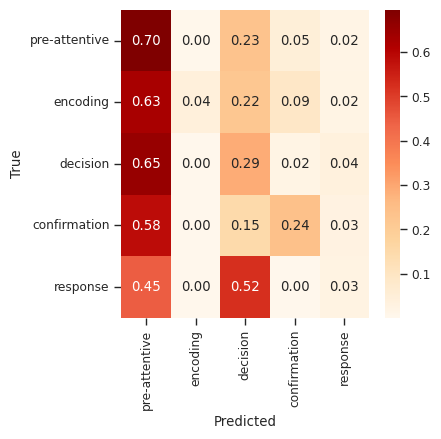

In [23]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)